### Customer Churn Prediction Using Artificial Neural Network (ANN)

Customer churn prediction is to measure why customers are leaving a business. In this tutorial we will be looking at customer churn in telecom business. We will build a deep learning model to predict the churn and use precision,recall, f1-score to measure performance of our model.

### Objective

Given information concerning  Bank customers , can we build a classifier which can determine whether they will leave in the next 6 months?

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

#### Load the data

In [2]:
df = pd.read_csv(r"C:\Users\SD\Downloads\Bank Turnover Dataset\Churn_Modelling.csv")
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
### Drop Row Number, Surname  and Customer ID column as they have no use in training the model

df.drop(['CustomerId','Surname','RowNumber'] ,axis='columns',inplace=True)


In [4]:
df.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [5]:
### Check the datatypes of the columns\

df.dtypes


CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [6]:
df.shape


(10000, 11)

In [7]:
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [8]:
(df['EstimatedSalary'] < 0).sum()


np.int64(0)

In [9]:
(df['Balance'] < 0).sum()


np.int64(0)

### Exploratory Data Analysis

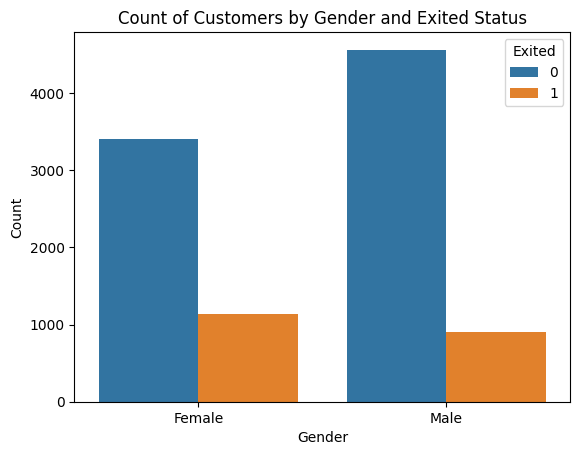

In [10]:
### Churn rate by Gender
sns.countplot(x='Gender', hue='Exited', data=df)
plt.title("Count of Customers by Gender and Exited Status")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title='Exited')
plt.show()

Females have the highest churn rate, compared to the Male, even though the difference is not that much.

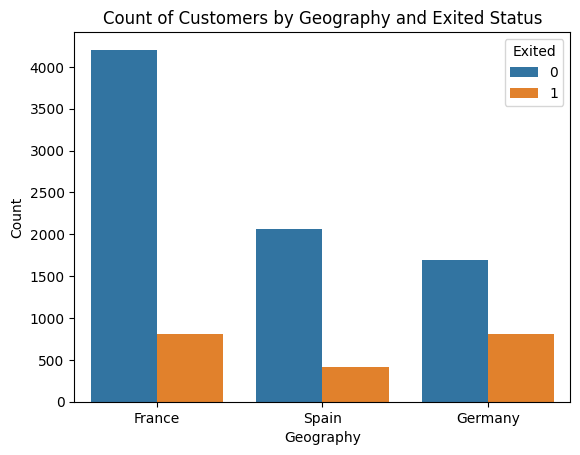

In [11]:
### Churn rate by Geography
sns.countplot(x='Geography', hue='Exited', data=df)
plt.title("Count of Customers by Geography and Exited Status")
plt.xlabel("Geography")
plt.ylabel("Count")
plt.legend(title='Exited')
plt.show()

Germany has the highest churn rate, followed by France.


C:\Users\SD\AppData\Local\Temp\ipykernel_25504\2757343144.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Gender', y='Balance', hue='Exited', data=df, ci=None)


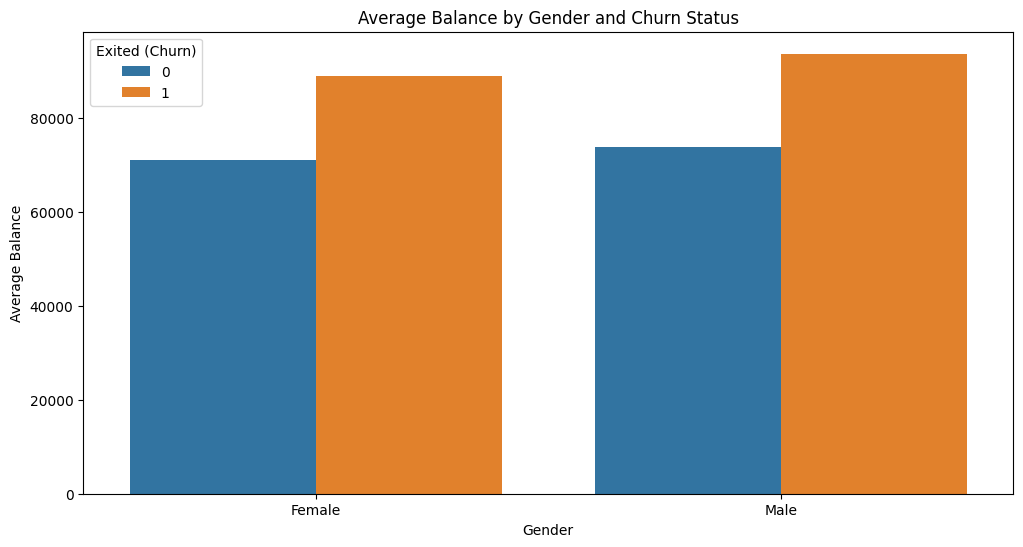

In [12]:
### Average Balance by Gender and Churn Status
plt.figure(figsize=(12,6))
sns.barplot(x='Gender', y='Balance', hue='Exited', data=df, ci=None)
plt.xlabel('Gender')
plt.ylabel('Average Balance')
plt.title('Average Balance by Gender and Churn Status')
plt.legend(title='Exited (Churn)')
plt.show()


Customers belonging to the Male and Female Gender who churned had a good amount of money in their bank account balance.

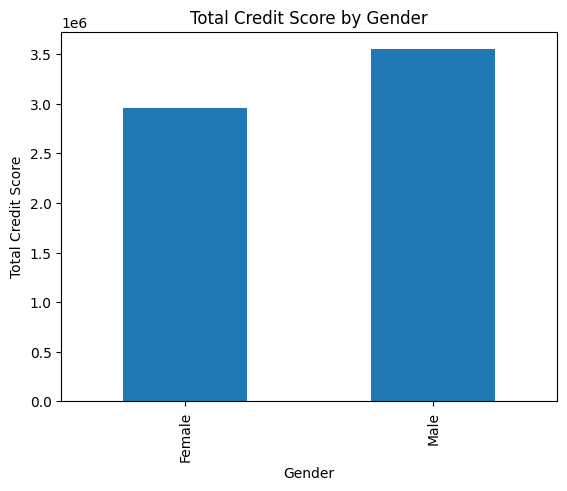

In [13]:
### Sum of credit score by Gender
df.groupby('Gender')['CreditScore'].sum().plot(kind='bar', title='Total Credit Score by Gender')
plt.ylabel('Total Credit Score')
plt.show()


The Male has a higher credit score than the females.

<Axes: title={'center': 'Churn Rate Distribution'}, xlabel='Exited'>

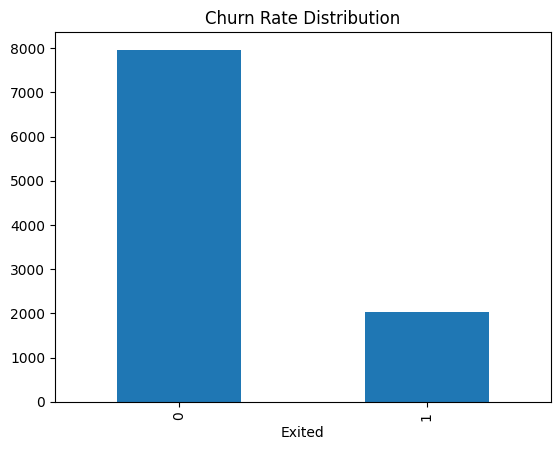

In [14]:
### Distribution of the target variable
df['Exited'].value_counts().plot(kind = 'bar', title ='Churn Rate Distribution' )

From the distribution, we can see that most customers in our database did not leave. However, using this imbalanced target variable will create bias when training the model to predict churn. We will be treating this imbalance.

### Split the Dataset

Splitting the data before encoding, scaling, and applying SMOTE is the right approach to avoid data leakage.

In [15]:
from sklearn.model_selection import train_test_split

X = df.drop('Exited', axis=1)
y = df['Exited']

# Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [16]:
## Preprocessing (Encoding + Scaling)

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder





In [17]:


categorical_cols = ['Gender', 'Geography']

# One-hot encode categorical columns (train only)
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True).astype('int')
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True).astype('int')

X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)


In [18]:


numerical_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

scaler = StandardScaler()

# Fit only on training data
X_train_encoded[numerical_cols] = scaler.fit_transform(X_train_encoded[numerical_cols])

# Transform test data using  scaler
X_test_encoded[numerical_cols] = scaler.transform(X_test_encoded[numerical_cols])


In [19]:
print("Train shape:", X_train_encoded.shape)
print("Test shape:", X_test_encoded.shape)


Train shape: (8000, 11)
Test shape: (2000, 11)


In [20]:

### Applying SMOTE 

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_encoded, y_train)


In [22]:
X_train_encoded.head(1)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
2151,1.058568,1.715086,7,-1.226058,1,1,0,1.042091,1,0,0


In [23]:
y_train_balanced.value_counts()

Exited
1    6370
0    6370
Name: count, dtype: int64

### Build a model (ANN) in tensorflow/keras



In [33]:
import tensorflow as tf
from tensorflow import keras

input_dim = X_train_balanced.shape[1]

model = keras.Sequential([
    keras.layers.Dense(11, input_shape=(input_dim,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.fit(X_train_balanced, y_train_balanced, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50


C:\Users\SD\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6156 - loss: 0.6504 - val_accuracy: 0.4490 - val_loss: 0.8131
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7342 - loss: 0.5327 - val_accuracy: 0.5785 - val_loss: 0.7138
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7445 - loss: 0.5119 - val_accuracy: 0.5569 - val_loss: 0.7433
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7422 - loss: 0.5158 - val_accuracy: 0.6122 - val_loss: 0.6929
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7567 - loss: 0.5057 - val_accuracy: 0.6637 - val_loss: 0.6202
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7628 - loss: 0.4948 - val_accuracy: 0.6593 - val_loss: 0.6303
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7576 - loss: 0.5024 - val_accuracy: 0.6354 - val_loss: 0.6709
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7700 - loss: 0.4849 - val_accuracy: 0.6664 - val_

In [34]:
## Evaluating the accuracy when tested on the test data
model.evaluate(X_test_encoded, y_test)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8525 - loss: 0.3572


[0.3781879246234894, 0.840499997138977]

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predict probabilities
y_pred_probs = model.predict(X_test_encoded)

# Convert to class labels (0 or 1)
y_pred = (y_pred_probs > 0.4).astype("int32")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
print(confusion_matrix(y_test, y_pred))

# AUC score
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_probs))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.84      0.88      1593
           1       0.53      0.69      0.60       407

    accuracy                           0.81      2000
   macro avg       0.72      0.77      0.74      2000
weighted avg       0.84      0.81      0.82      2000

[[1344  249]
 [ 125  282]]
ROC-AUC Score: 0.8489444760631202


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


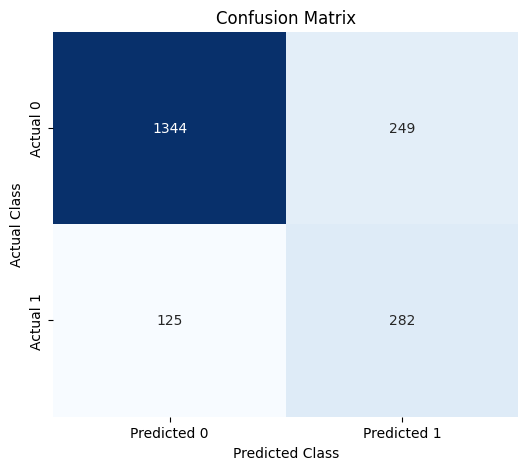

In [36]:
# Predict classes
y_pred_classes = (model.predict(X_test_encoded) > 0.4).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()


Findings from Model Evaluation:

The model correctly identified 1344 customers who did not churn (True Negatives).

It incorrectly predicted 249 customers as churners when they actually did not churn (False Positives).

The model missed 125 actual churners, predicting them as non-churners (False Negatives).

It successfully detected 282 customers who did churn (True Positives).

The ROC-AUC score of 0.85 indicates the model has good ability to distinguish between churners and non-churners.

An accuracy of 85% on the training data and an accuracy of ~85% and loss of 0.35 on the test data shows the model is learning well and generalizing fairly nicely.

Performance can be improved by adding more layers or neurons, trying different activation functions and increasing number of epoch.


Overall, the model performs well but can be further improved to reduce missed churners and false alarms.
